# Explicación uso de kernels

---



**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Abril 2025

**Versión:** 1.0  



---

## Descripción

Este notebook muestra el efecto de los kernels

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- numpy (2.0.2)
- tensorflow (2.18.0)
- matplotlib (3.10.0)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Sequential


# Paso 1. Cargar imagen en escala de grises

In [ ]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/master/imagenes/images.jpeg

--2025-04-28 00:37:26--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/master/imagenes/images.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7283 (7.1K) [image/jpeg]
Saving to: ‘images.jpeg’

images.jpeg         100%[===================>]   7.11K  --.-KB/s    in 0s      

2025-04-28 00:37:27 (64.6 MB/s) - ‘images.jpeg’ saved [7283/7283]



In [ ]:
# Obtiene la imagen
img = cv2.imread('images.jpeg', cv2.IMREAD_GRAYSCALE)
# Redimensiona para facilidad
img = cv2.resize(img, (128, 128))
# Normalizar entre 0 y 1
img = img.astype('float32') / 255.0

# Expande dimensiones para Conv2D [batch, height, width, channels]
# La entrada que espera una capa Conv2D siempre debe tener 4 dimensiones
#img_input = np.expand_dims(np.expand_dims(img, axis=0), axis=-1)
img_input = img.reshape((1, 128, 128, 1))



```
np.expand_dims(img, axis=0)
```

➡️ Agrega la dimensión de batch (cantidad de imágenes).

➡️ Cambia de (128, 128) a (1, 128, 128).



```
np.expand_dims(..., axis=-1)
```


➡️ Agrega la dimensión de canales (color o escala de grises).

➡️ Cambia de (1, 128, 128) a (1, 128, 128, 1).

In [ ]:
# Examina la forma de la imagen, esto es lo que necesita la capa convolucional
img_input.shape

(1, 128, 128, 1)

# Paso 2. Definir kernels

In [ ]:
kernels = {
    'Original': np.array([[[[1]]]], dtype=np.float32),  # filtro identidad
    'Laplacian': np.array([
        [[-1], [-1], [-1]],
        [[-1], [8], [-1]],
        [[-1], [-1], [-1]]
    ], dtype=np.float32),
    'Sobel_X': np.array([
        [[-1], [0], [1]],
        [[-2], [0], [2]],
        [[-1], [0], [1]]
    ], dtype=np.float32),
    'Gaussian_Blur': np.array([
        [[1/16], [2/16], [1/16]],
        [[2/16], [4/16], [2/16]],
        [[1/16], [2/16], [1/16]]
    ], dtype=np.float32),
    'Sharpen': np.array([
        [[0], [-1], [0]],
        [[-1], [5], [-1]],
        [[0], [-1], [0]]
    ], dtype=np.float32)
}

# Paso 3. Función para aplicar kernel

In [ ]:
def aplicar_kernel(img, kernel):
    modelo = Sequential([
        Input(shape=(None, None, 1)),
        Conv2D(
            filters=1, kernel_size=kernel.shape[0],
            padding='same', use_bias=False)
    ])

    kernel = kernel.reshape((kernel.shape[0], kernel.shape[1], 1, 1))
    modelo.layers[0].set_weights([kernel])
    return modelo.predict(img)


# Paso 4. Aplicar todos los filtros

In [ ]:
resultados = {}
for nombre, k in kernels.items():
  salida = aplicar_kernel(img_input, k)
  resultados[nombre] = salida[0, ..., 0]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


# Paso 5. Mostrar resultados


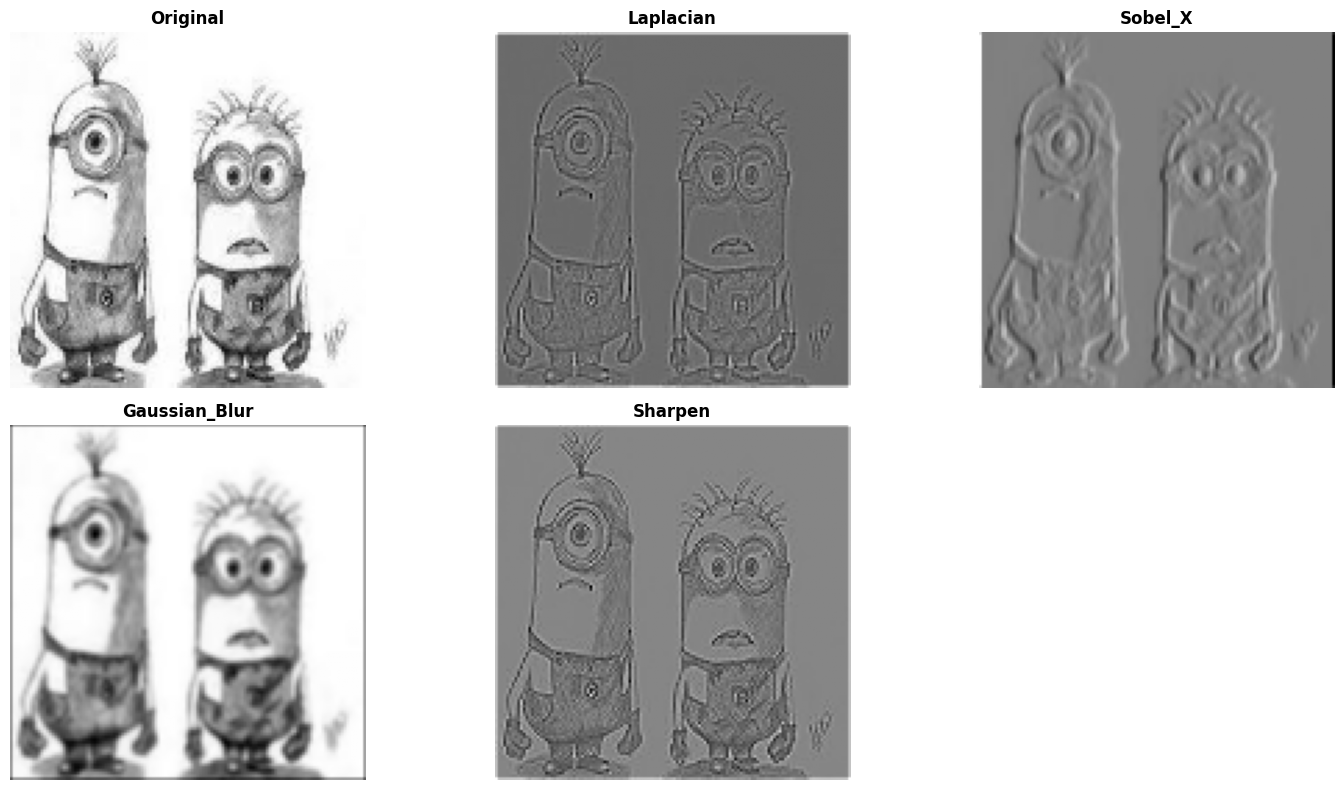

In [ ]:
plt.figure(figsize=(15, 8))
for indice, (nombre, resultado) in enumerate(resultados.items()):
  plt.subplot(2, 3, indice+1)
  plt.imshow(resultado, cmap='gray')
  plt.title(nombre, fontsize=12, fontweight="bold")
  plt.axis('off')

plt.tight_layout()
plt.show()

# Bonus track - parámetro *use_bias*

In [ ]:
# Crear imagen de prueba
imagen = np.array([[1, 2, 0],
                   [0, 1, 3],
                   [1, 0, 2]], dtype=np.float32)
imagen = imagen.reshape(1, 3, 3, 1)

# Filtro fijo que suma los valores (kernel de unos)
kernel = np.ones((3, 3, 1, 1), dtype=np.float32)

# Capa con bias
capa_bias = tf.keras.layers.Conv2D(filters=1, kernel_size=3, use_bias=True)
# Capa sin bias
capa_sin_bias = tf.keras.layers.Conv2D(filters=1, kernel_size=3, use_bias=False)

# Inicializar pesos (kernel y bias manualmente para comparar)
capa_bias.build(imagen.shape)
capa_sin_bias.build(imagen.shape)

# Asignar el mismo kernel (de unos) a ambas capas
capa_bias.set_weights([kernel, np.array([0.5])])  # Kernel + Bias de 0.5
capa_sin_bias.set_weights([kernel])               # Solo kernel

# Aplicar capas
resultado_bias = capa_bias(imagen)
resultado_sin_bias = capa_sin_bias(imagen)

print("Resultado CON bias (0.5 agregado):")
print(resultado_bias.numpy())

print("\nResultado SIN bias:")
print(resultado_sin_bias.numpy())


Resultado CON bias (0.5 agregado):
[[[[10.5]]]]

Resultado SIN bias:
[[[[10.]]]]
